In [20]:
import numpy as np
from scipy.integrate import trapz
import matplotlib.pyplot as plt


class CodeWrapper:
    def __init__(self, X1, X2, Y1, Y2, m, n, hx, hy, m_values, gamma_values, fV_values, B1, B2, XD):
        self.X1 = X1
        self.X2 = X2
        self.Y1 = Y1
        self.Y2 = Y2
        self.m = m
        self.n = n
        self.hx = hx
        self.hy = hy
        self.x = np.linspace(self.X1, self.X2, self.n)
        self.y = np.linspace(self.Y1, self.Y2, self.m)
        self.m_values = m_values
        self.gamma_values = gamma_values
        self.fV_values = fV_values
        self.B1 = B1
        self.B2 = B2
        self.XD = XD

    def f(self, x, M, G, F):
        return F**2 * ((M**4 + M**2 * G**2) / (24 * np.pi * ((x - M**2)**2 + M**2 * G**2)))

    def define_functions(self):
        self.f1 = self.f(self.x, self.m_values[0], self.gamma_values[0], 1)
        self.f2 = self.f(self.x, self.m_values[1], self.gamma_values[1], 1)
        self.f3 = self.f(self.x, self.m_values[2], self.gamma_values[2], 1)
        self.f4 = self.f(self.x, self.m_values[3], self.gamma_values[3], 1)
        self.F = self.f1 + self.f2 + self.f3 + self.f4

    def calculate_F1_F2(self):
        self.F1 = self.f1
        self.F2 = self.x - self.x

    def initialize_arrays(self):
        self.G1 = np.zeros((self.m,))
        self.G2 = np.zeros((self.m,))
        self.G3 = np.zeros((self.m,))
        self.g_exact = np.zeros((self.n,))
        self.g_delta = np.zeros((self.n,))
        self.U_exact = np.zeros((self.n,))
        self.G_exact = np.zeros((self.n,))
        self.G_delta = np.zeros((self.n,))
        self.Aphi = np.zeros((self.m, self.n))
        self.A = np.zeros((self.n, self.n))
        self.ba = np.zeros(self.n)
        self.M = np.zeros((self.n, self.n))
        self.M1 = np.zeros((self.n, self.n))
        self.H1 = np.zeros((self.n, self.n))
        self.alpha = np.zeros(20)
        self.ua = np.zeros((self.n - 2, 20))
        self.Ua = np.zeros((self.n, 20))
        self.fa = np.zeros((self.n, 20))
        self.res = np.zeros(20)
        self.err = np.zeros(20)
        self.L = np.zeros(20)
        self.LH = np.zeros(20)
        self.V = np.zeros((20, 1))
        self.Rho = np.zeros((20, 1))

    def calculate_G1_G2_G3(self):
        for i in range(self.m):
            self.G1[i] = trapz(1 / (self.y[i] - self.x) * self.F1, self.x)
            self.G2[i] = trapz(1 / (self.y[i] - self.x) * self.F2, self.x)
            self.G3[i] = trapz(1 / (self.y[i] - self.x) * self.V_exact, self.x)

    def calculate_f_exact_f_delta(self):
        self.f_exact = self.B1 * self.F1 + self.B2 * self.F2
        self.f_delta = self.XD * self.B1 * self.F1 + self.XD * self.B2 * self.F2

    def calculate_V_exact(self):
        MM = self.f_delta[0]
        NN = self.f_delta[-1]
        self.V_exact = (MM * (self.x - self.X2)) / (self.X1 - self.X2) + \
            (NN * (self.x - self.X1)) / (self.X2 - self.X1)

    def calculate_g_exact_g_delta_U_exact_G_exact_G_delta(self):
        self.g_exact = self.B1 * self.G1 + self.B2 * self.G2
        self.g_delta = self.XD * self.B1 * self.G1 + self.XD * self.B2 * self.G2
        self.U_exact = self.f_exact - self.V_exact
        self.G_exact = self.g_exact - self.G3
        self.G_delta = self.g_delta - self.G3

    def calculate_Aphi_A_ba(self):
        for j in range(1, self.n - 1):
            self.Aphi[:, j] = 1 / self.hx * ((self.y - self.x[j - 1]) * np.log(self.y - self.x[j - 1])
                                             + (self.x[j - 1] - self.x[j]) + (self.y - self.x[j + 1]) *
                                             np.log(self.y - self.x[j + 1])
                                             - 2 * (self.y - self.x[j]) * np.log(self.y - self.x[j]) - (self.x[j] - self.x[j + 1]))
        self.Aphi[:, 0] = np.log(self.y - self.x[0]) + 1 / self.hx * ((self.y - self.x[1]) * np.log(self.y - self.x[1])
                                                                      - (self.y - self.x[0]) * np.log(self.y - self.x[0]) - (self.x[0] - self.x[1]))
        self.Aphi[:, -1] = -np.log(self.y - self.x[-1]) + 1 / self.hx * (-(self.y - self.x[-1]) * np.log(self.y - self.x[-1])
                                                                         + (self.y - self.x[-2]) * np.log(self.y - self.x[-2]) + (self.x[-2] - self.x[-1]))
        for i in range(self.n):
            for j in range(self.n):
                self.A[i, j] = trapz(self.Aphi[:, i] * self.Aphi[:, j], self.y)
            self.ba[i] = trapz(self.Aphi[:, i] * self.G_delta, self.y)

    def calculate_M_M1_H1(self):
        self.M[0, 0] = 4
        self.M[0, 1] = 2
        for i in range(1, self.n - 1):
            self.M[i, i] = 8
            self.M[i, i - 1] = 2
            self.M[i, i + 1] = 2
        self.M[-1, -1] = 4
        self.M[-1, -2] = 2
        self.M = self.hx / 12 * self.M
        self.M1[0, 0] = 1
        self.M1[0, 1] = -1
        for i in range(1, self.n - 1):
            self.M1[i, i] = 2
            self.M1[i, i - 1] = -1
            self.M1[i, i + 1] = -1
        self.M1[-1, -1] = 1
        self.M1[-1, -2] = -1
        self.M1 = 1 / self.hx * self.M1
        self.H1 = self.M + self.M1

    def remove_boundary_conditions(self):
        self.A = np.delete(self.A, [0, self.n - 2], axis=0)
        self.A = np.delete(self.A, [0, self.n - 2], axis=1)
        self.ba = np.delete(self.ba, [0, self.n - 2])
        self.H1 = np.delete(self.H1, [0, self.n - 2], axis=0)
        self.H1 = np.delete(self.H1, [0, self.n - 2], axis=1)

    def iterate(self):
        for k in range(20):
            self.alpha[k] = 10**(-k-1)
            self.ua[:, k] = np.linalg.inv(
                self.A + self.alpha[k] * self.H1) @ self.ba
            self.Ua[:, k] = np.concatenate(([0], self.ua[:, k], [0]))
            self.fa[:, k] = self.Ua[:, k] + self.V_exact
            self.res[k] = np.sqrt(
                trapz((self.Aphi @ self.fa[:, k] - self.G_delta)**2, self.y))
            self.err[k] = np.sqrt(
                trapz((self.fa[:, k] - self.f_exact)**2, self.x))
            self.L[k] = np.sqrt(trapz(self.fa[:, k]**2, self.x)) * self.res[k]
            self.LH[k] = np.sqrt(
                trapz(self.fa[:, k]**2 + (np.gradient(self.fa[:, k]))**2, self.x)) * self.res[k]
            # Plot results (uncomment this block if you want to plot)
            plt.figure(1)
            # plt.figure(1, dpi=1000)
            plt.subplot(4, 5, k + 1)
            plt.plot(self.x, self.f_exact, self.x, self.fa[:, k], linewidth=3)
            plt.title(str(self.alpha[k]))

    def find_indices(self):
        kl = np.argmin(np.abs(self.L))
        klh = np.argmin(np.abs(self.LH))
        for i in range(20):
            self.V[i] = np.linalg.norm(self.Aphi @ np.linalg.inv(self.Aphi.T @
                                                                 self.Aphi + self.alpha[i] * np.eye(len(self.x))) @ self.Aphi.T @ self.G_delta)**2 / \
                np.trace((np.eye(len(self.y)) - self.Aphi @ np.linalg.inv(self.Aphi.T @
                                                                          self.Aphi + self.alpha[i] * np.eye(len(self.x))) @ self.Aphi.T)**2)
        for i in range(20):
            self.Rho[i] = np.linalg.norm(self.fa[:, i] / (self.alpha[i] *
                                                          (self.Aphi.T @ self.Aphi + self.alpha[i] * np.eye(len(self.x)))))
        Vm = np.min(self.V)
        Vi = np.argmin(self.V)
        Rm = np.min(self.Rho)
        Ri = np.argmin(self.Rho)
        return [['L-curve+L^2', 'L-curve+H^1', 'GCV', 'Approx. Optimal'],
                [kl + 1, klh + 1, Vi + 1, Ri + 1]]  # Add 1 to indices to match MATLAB indexing

    def run(self):
        self.initialize_arrays()
        self.define_functions()
        self.calculate_F1_F2()
        self.calculate_f_exact_f_delta()
        self.calculate_V_exact()
        self.calculate_G1_G2_G3()
        self.calculate_g_exact_g_delta_U_exact_G_exact_G_delta()
        self.calculate_Aphi_A_ba()
        self.calculate_M_M1_H1()
        self.remove_boundary_conditions()
        self.iterate()
        return self.find_indices()

In [21]:
# if __name__ == "__main__":
X1 = 0
X2 = 2
Y1 = X2 + 0.01
Y2 = 30 + 0.01
n = int((X2 - X1) * 1000 + 1)
m = int((Y2 - Y1) * 100 + 1)
hx = (X2 - X1) / (n - 1)
hy = (Y2 - Y1) / (m - 1)
m_values = [0.78, 1.46, 1.72, 1.90]
gamma_values = [0.15, 0.4, 0.25, 0.1]
fV_values = [0.22, 0.19, 0.14, 0.14]
B1, B2 = 1, 2
XD = 1.01
code_wrapper = CodeWrapper(
    X1, X2, Y1, Y2, m, n, hx, hy, m_values, gamma_values, fV_values, B1, B2, XD)

In [22]:
code_wrapper.initialize_arrays()
code_wrapper.define_functions()

In [23]:
code_wrapper.calculate_F1_F2()
code_wrapper.calculate_f_exact_f_delta()
code_wrapper.calculate_V_exact()

In [24]:
code_wrapper.calculate_G1_G2_G3()

In [25]:
code_wrapper.calculate_g_exact_g_delta_U_exact_G_exact_G_delta()

In [26]:
code_wrapper.calculate_Aphi_A_ba()

In [27]:
code_wrapper.calculate_M_M1_H1()
code_wrapper.remove_boundary_conditions()

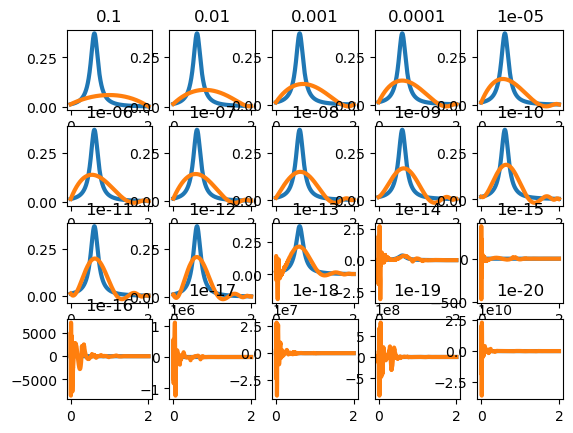

In [28]:
code_wrapper.iterate()

In [ ]:
print(code_wrapper.find_indices())


In [ ]:
result = code_wrapper.run()
print(result)
